C:\Users\Vishal\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['No.' 'Time' 'Length']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\Vishal\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:53:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Vishal\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['No.' 'Time' 'Length']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Best Params: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 50}

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        70

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160



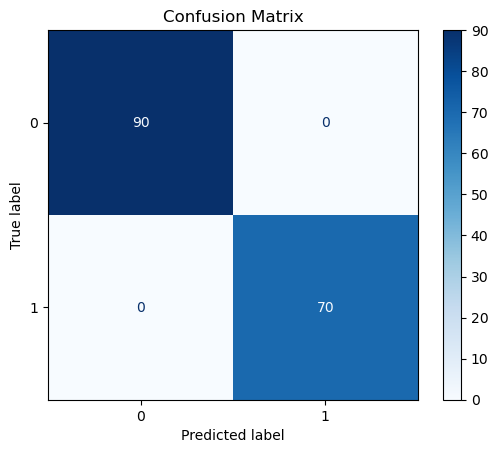

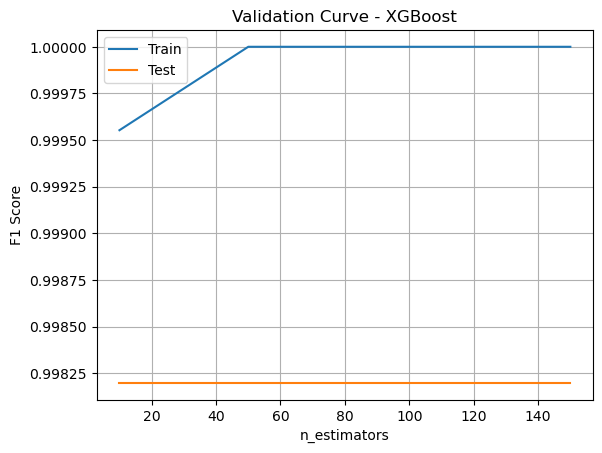

In [2]:
# Smart Grid Cyber Attack Detection - Full ML Project in Colab

# ✅ SECTION 1: Imports & Setup
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import ipywidgets as widgets
from IPython.display import display, clear_output

# ✅ SECTION 2: Load & Preprocess Dataset
uploaded = pd.read_csv("Updated_Electron_Attack_Data_With_Labels.csv")  # Replace with your uploaded dataset

# Drop non-numeric columns
df = uploaded.select_dtypes(include=[np.number])

# Drop rows with excessive NaNs
df = df.dropna(thresh=5)

# Impute remaining NaNs with column means
df.fillna(df.mean(), inplace=True)

# Extract features and labels (assumes you added 'label' column)
X = df.drop("label", axis=1)
y = df["label"]

# ✅ SECTION 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ✅ SECTION 4: Train Model with GridSearchCV + Pipeline
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("clf", XGBClassifier(eval_metric='logloss', use_label_encoder=False))
])

param_grid = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [3, 6],
    'clf__learning_rate': [0.01, 0.1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipeline, param_grid=param_grid, scoring='f1', cv=cv, n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
joblib.dump(best_model, "xgboost_attack_model.pkl")

# ✅ SECTION 5: Evaluate Model
print("Best Params:", grid.best_params_)
y_pred = best_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ✅ SECTION 6: Validation Curve
train_scores, test_scores = validation_curve(
    best_model, X_train, y_train,
    param_name='clf__n_estimators', param_range=[10, 50, 100, 150],
    cv=cv, scoring='f1', n_jobs=-1
)

plt.plot([10, 50, 100, 150], train_scores.mean(axis=1), label="Train")
plt.plot([10, 50, 100, 150], test_scores.mean(axis=1), label="Test")
plt.xlabel("n_estimators")
plt.ylabel("F1 Score")
plt.title("Validation Curve - XGBoost")
plt.legend()
plt.grid()
plt.show()

# ✅ SECTION 7: Simple Prediction Interface in Colab
feature_names = X.columns.tolist()
input_widgets = {feat: widgets.FloatText(description=feat, value=0.0, layout=widgets.Layout(width='300px')) for feat in feature_names}

predict_button = widgets.Button(description="🔍 Predict", button_style='primary')
output = widgets.Output()


def on_click(b):
    with output:
        clear_output()
        input_data = {feat: input_widgets[feat].value for feat in feature_names}
        df_input = pd.DataFrame([input_data])
        pred = best_model.predict(df_input)[0]
        prob = best_model.predict_proba(df_input)[0][pred]
        if pred == 1:
            print(f"⚠️ Attack Detected with Confidence: {prob:.2%}")
        else:
            print(f"✅ Normal Operation with Confidence: {prob:.2%}")

predict_button.on_click(on_click)
display(widgets.VBox(list(input_widgets.values()) + [predict_button, output]))
